# Ground Layer Adaptive Optics

In [1]:
import math
import numpy as np
import ceo
import yaml
import matplotlib.pyplot as plt
%matplotlib inline

# Atmosphere

We define 2 atmospheres:

 * the first for purpose of testing is a single layer at the ground:

In [2]:
atm =  ceo.Atmosphere(0.15,30)

 * the second correspond to the GMT turbulence profile with strong turbulence near the ground

In [3]:
atm =  ceo.GmtAtmosphere(0.15,30,ID=2)

A V band on-axis source is defined first,

# Wavefront sensor

We define 3 48x48 SH-WFSs with 3 GSs at 6 arcmin evenly spread on a circle 

In [4]:
D = 25.5
NL = 48
NA = NL+1
zen = np.ones(3)*6
azi = np.arange(3)*2*np.pi/3
#ngs = ceo.Source('Vs',zenith=zen*ceo.constants.ARCMIN2RAD,azimuth=azi,resolution=(NA,NA))

In [5]:
gmt = ceo.GMT_MX()


wfs = ceo.ShackHartmann(NL,16,D/NL,N_PX_IMAGE=24,BIN_IMAGE=3,N_GS=3)

N = NL*16+1

nngs = ceo.Source('Vs',zenith=zen*ceo.constants.ARCMIN2RAD,azimuth=azi,
                  rays_box_size=25.5,rays_box_sampling=N,rays_origin=[0,0,25])

nngs>>(gmt,)

+nngs

v2h  = lambda x : np.hstack(np.vsplit(x,3))

wfs.calibrate(nngs,0.2)

nngs>>(gmt,wfs)
+nngs



In [6]:
wfs.n_valid_lenslet

4042

In [7]:
def display():
    
    fig = plt.figure(figsize=(20, 21))
    grid = plt.GridSpec(8, 6, wspace=0.4, hspace=0.3)

    ax = plt.subplot(grid[0,1:4])
    h = ax.imshow(v2h(1e6*nngs.phase.host()),cmap='cividis')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.colorbar(h,ax=ax,label="WFE [micron]")

    ax = plt.subplot(grid[1:-1,:])
    ax.imshow(np.vsplit(wfs.frame.host(),3)[0],cmap='inferno')
    ax.set_xticks(np.arange(0,NL)*wfs.camera.N_PX_FRAME/NL)
    ax.set_xticklabels([])
    ax.set_yticks(np.arange(0,NL)*wfs.camera.N_PX_FRAME/NL)
    ax.set_yticklabels([])
    ax.grid(alpha=0.2)

    ax = plt.subplot(grid[-1,:])
    h = ax.imshow(np.hstack(np.vsplit(wfs.c.host(units='arcsec').reshape(NL*2*nngs.N_SRC,NL),nngs.N_SRC*2)),cmap='cividis')
    fig.colorbar(h,ax=ax,label="Slopes [arcsec]")
    ax.set_xticks(np.arange(0,NL*6,NL,))
    ax.set_yticks([])
    ax.grid()

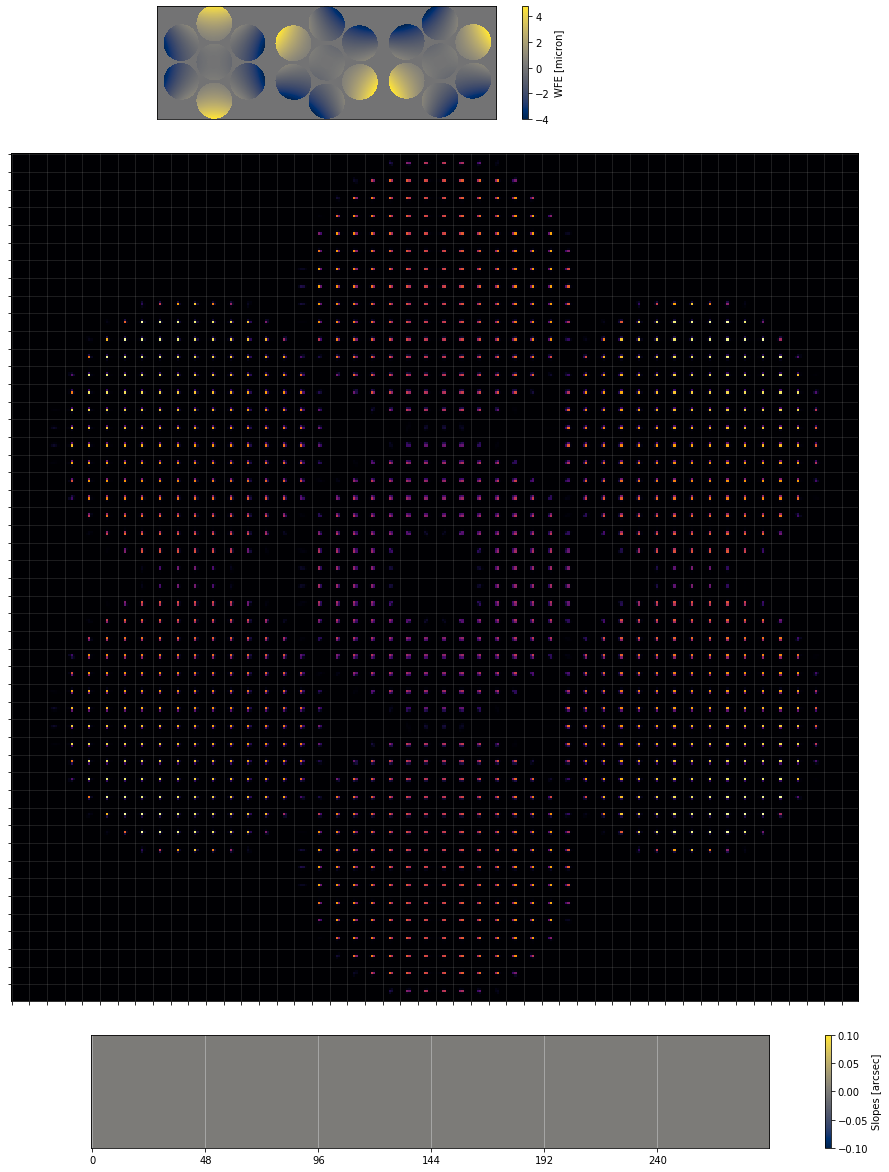

In [8]:
display()

In [9]:
wfs.pixel_scale_arcsec

0.2911973743824343

Sampling a 10' diameter field of view:

In [10]:
data = np.loadtxt("KPP_field_sampler.csv",delimiter=',',skiprows=1)
zen_sc = data[:,0]
azi_sc = data[:,1]*np.pi/180

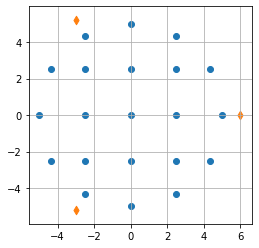

In [11]:
fig,ax = plt.subplots()
x_sc = zen_sc*np.cos(azi_sc)
y_sc = zen_sc*np.sin(azi_sc)
ax.scatter(x_sc,y_sc)
x = zen*np.cos(azi)
y = zen*np.sin(azi)
ax.scatter(x,y,marker='d')
ax.grid()
ax.set_aspect('equal')

In [12]:
src = ceo.Source('Vs',zenith=zen_sc*ceo.constants.ARCMIN2RAD,azimuth=azi_sc,resolution=(NA,NA))

On-axis source:

In [13]:
src0 = ceo.Source("Vs",rays_box_size=25.5,rays_box_sampling=NA,rays_origin=[0,0,25])
src0>>(gmt,)
+src0

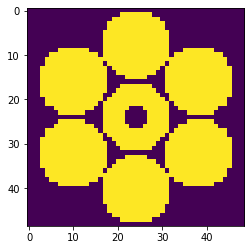

In [14]:
dm  = ceo.Mask(NA,D)
dm.alter(ceo.cuFloatArray(host_data=src0.wavefront.amplitude.host()))
plt.imshow(dm.f.host().reshape(-1,NA))

Off-axis wavefront:

In [15]:
src.masked(dm)

In [16]:
p = D/(NA-1)
atm.get_phase_screen(src,p,NA,p,NA,0.0)
src_phase = src.phase.host(units='micron')#,zm=True,mask=dm_mask.host())

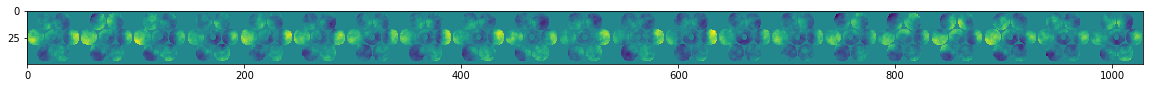

In [17]:
fig,ax=plt.subplots(figsize=(20,4))
ax.imshow(src_phase.T)

On axis wavefront:

In [18]:
atm.get_phase_screen(src0,p,NA,p,NA,0.0)
src0_phase = src0.phase.host(units='micron',zm=True,mask=dm.f.host())
A = src0.amplitude.host()

Wavefront sensing:

In [19]:
nngs.reset()
p = D/(N-1)
atm.get_phase_screen(nngs,p,N,p,N,0.0)
gmt.propagate(nngs)


wfs.reset()
wfs.analyze(nngs)

cc = wfs.c.host(units='arcsec')

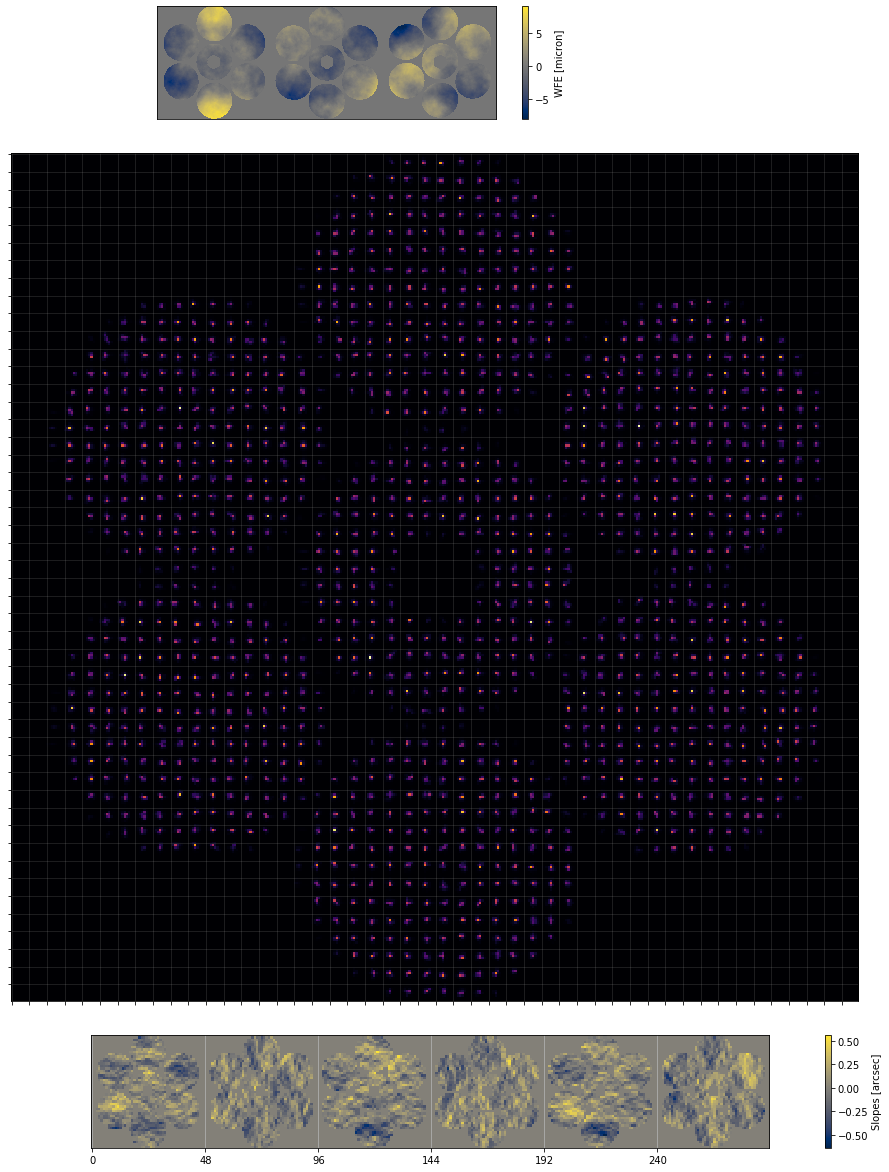

In [20]:
display()

# Wavefront reconstruction

In [21]:
d = D/NL
palmmse = ceo.ALmmse(atm,nngs,ceo.constants.ARCMIN2RAD*5,d,NL,dm,"MINRES")
palmmse.estimation(wfs.data_proc)
ppalmmse_phase = palmmse.phase.host(units='micron',zm=True,mask=dm.f.host())

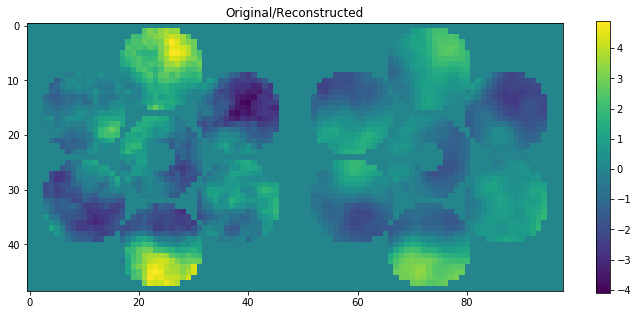

In [22]:
fig,ax = plt.subplots(figsize=(12,5))
h = ax.imshow(np.hstack([src0_phase,ppalmmse_phase]))
ax.set_title("Original/Reconstructed")
fig.colorbar(h,ax=ax)

Residual wavefront error

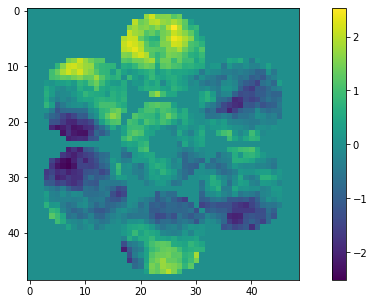

In [23]:
fig,ax = plt.subplots(figsize=(12,5))
h = ax.imshow((src0_phase-ppalmmse_phase)*A)
fig.colorbar(h,ax=ax)

In [24]:
m = dm.f.host()==1
e = src0_phase-ppalmmse_phase
print("WFE RMS: {:.0f}nm".format(1e3*e.reshape(-1,1)[m].std()))

WFE RMS: 972nm


WFE in the field:

In [25]:
m = dm.f.host().ravel()==1
wfe_rms = 1e3*src_phase.reshape(-1,NA*NA)[:,m].std(-1)

res_wfe_rms = 1e3*(src_phase.reshape(-1,49*49)-ppalmmse_phase.reshape(-1,NA*NA))[:,m].std(-1)

print("WFE RMS [nm]:")
print(" * before GLAO: {}".format(np.array_str(wfe_rms,precision=0)))
print(" * after GLAO: {}".format(np.array_str(res_wfe_rms,precision=0)))

WFE RMS [nm]:
 * before GLAO: [1767. 1922. 1793. 1539. 1824. 1807. 1676. 1850. 1786. 1802. 1605. 1708.
 1885. 1587. 1592. 1780. 1803. 1926. 2082. 1581. 1679.]
 * after GLAO: [ 972. 1173. 1202.  981.  940. 1051.  977.  907. 1029. 1088. 1083. 1056.
 1006.  978. 1101. 1201. 1370. 1333. 1540. 1153. 1012.]


# Zonal reconstruction

In [26]:
n = 11
NA = n*NL+1

In [27]:
src0 = ceo.Source("Vs",rays_box_size=25.5,rays_box_sampling=NA,rays_origin=[0,0,25])
src0>>(gmt,)
+src0

In [28]:
pssn = ceo.PSSn(src0,0.15,30)

In [29]:
srcs = ceo.Source("Vs",zenith=zen*ceo.constants.ARCMIN2RAD,azimuth=azi,
                  rays_box_size=25.5,rays_box_sampling=NA,rays_origin=[0,0,25])
srcs>>(gmt,)
+srcs

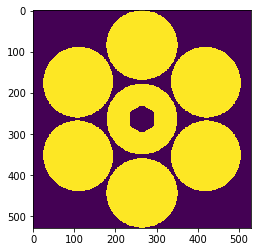

In [30]:
dm  = ceo.Mask(NA,D)
dm.alter(ceo.cuFloatArray(host_data=src0.wavefront.amplitude.host()))
#dm.alter(ceo.cuFloatArray(host_data=srcs.wavefront.amplitude.host().prod(0)))
plt.imshow(dm.f.host().reshape(-1,NA))

In [31]:
palmmse = ceo.ALmmse(atm,nngs,0,d,NL,dm,"MINRES",osf=n)
palmmse.estimation(wfs.data_proc)

In [32]:
ppalmmse_phase = palmmse.phase.host(units='micron',zm=True,mask=dm.f.host())

In [33]:
p = D/(NA-1)
atm.get_phase_screen(src0,p,NA,p,NA,0.0)
src0_phase = src0.phase.host(units='micron',zm=True,mask=dm.f.host())

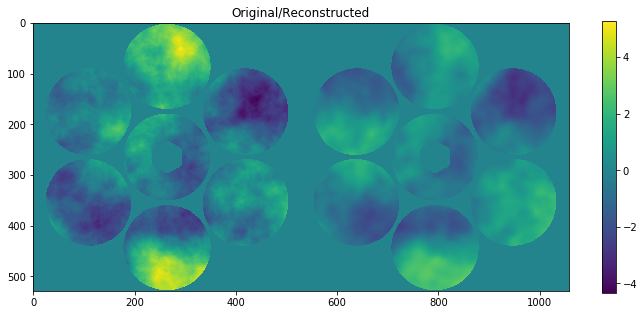

In [34]:
fig,ax = plt.subplots(figsize=(12,5))
h = ax.imshow(np.hstack([src0_phase,ppalmmse_phase]))
ax.set_title("Original/Reconstructed")
fig.colorbar(h,ax=ax)

Residual wavefront error

In [35]:
src0.wavefront.axpy(-1,ceo.cuFloatArray(host_data=ppalmmse_phase*1e-6))

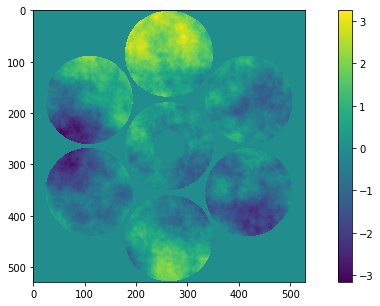

In [36]:
fig,ax = plt.subplots(figsize=(12,5))
h = ax.imshow(src0.phase.host(units='micron',zm=True,mask=dm.f.host()))
fig.colorbar(h,ax=ax)

In [37]:
print("WFE RMS: {:.0f}nm".format(float(src0.wavefront.rms(-9).ravel())))

WFE RMS: 1133nm


# Karhunen-Loeve @ M2

In [75]:
N_KL = 100
kgmt = ceo.GMT_MX(M1_mirror_modes="S12",M1_N_MODE=2,
                 M2_mirror_modes="M2_KarhunenLoeveModes_ortho_S7OC0.395_cubicInt",M2_N_MODE=N_KL)

In [76]:
src0 >> (kgmt,)

In [77]:
ksrc0 = ceo.Source("Vs",rays_box_size=25.5,rays_box_sampling=NA,rays_origin=[0,0,25])
ksrc0>>(kgmt,)
+ksrc0

In [80]:
kgmt.reset()
state = kgmt.state
calib = np.zeros((ksrc0.wavefront.phase.shape[1],7*N_KL))
k = 0
for sid in range(7):
    print(f"\n S{sid+1}: ",end="")
    for m in range(N_KL):
        print(f"\r S{sid+1}: {m:03d}",end="")
        state['M2']['modes'][sid,m] = 1e-6
        kgmt^=state
        +ksrc0
        ps = ksrc0.wavefront.phase.host().ravel().copy()
        state['M2']['modes'][sid,m] = -1e-6
        kgmt^=state
        +ksrc0
        ps -= ksrc0.wavefront.phase.host().ravel().copy()
        calib[:,k] = ps*0.5e6
        state['M2']['modes'][sid,m] = 0        
        k += 1


 S1: 099
 S2: 099
 S3: 099
 S4: 099
 S5: 099
 S6: 099
 S7: 099

In [81]:
calib.shape,np.linalg.cond(calib)

((279841, 700), 1.64700598761371)

In [82]:
res = np.linalg.lstsq(calib,ppalmmse_phase.ravel()*1e-6,rcond=None)

In [83]:
kgmt.reset()
+ksrc0

In [84]:
ksrc0.reset()
p = D/(NA-1)
atm.get_phase_screen(ksrc0,p,NA,p,NA,0.0)
kgmt.propagate(ksrc0)
ksrc0_phase = ksrc0.phase.host(units='micron',zm=True,mask=dm.f.host())
ksrc0_wfe_rms = float(ksrc0.wavefront.rms(-9).ravel())
print("WFE RMS: {:.0f}nm".format(ksrc0_wfe_rms))

WFE RMS: 1770nm


In [86]:
kgmt.reset()
state = kgmt.state
state['M2']['modes'][...] = -res[0].reshape(7,-1)
kgmt^=state
ksrc0.reset()
kgmt.propagate(ksrc0)
ps = ksrc0.phase.host(units='micron')#,zm=True,mask=dm.f.host())


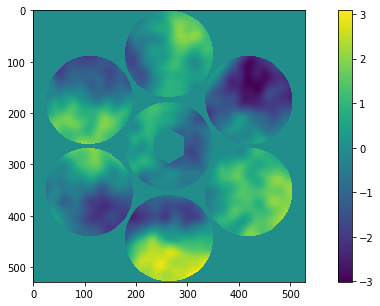

In [87]:
fig,ax = plt.subplots(figsize=(12,5))
h = ax.imshow(-ps)
fig.colorbar(h,ax=ax)

In [88]:
ps_wfe_rms  = float(ksrc0.wavefront.rms(-9).ravel())
ps_wfe_rms

1295.6667205799022

In [90]:
kgmt.reset()
state = kgmt.state
state['M2']['modes'][...] = -res[0].reshape(7,-1)
kgmt^=state
ksrc0.reset()
p = D/(NA-1)
atm.get_phase_screen(ksrc0,p,NA,p,NA,0.0)
kgmt.propagate(ksrc0)

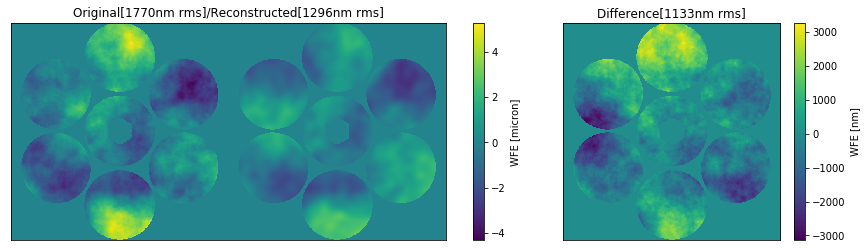

In [92]:
fig = plt.figure(figsize=(15, 4))
grid = plt.GridSpec(1, 3,wspace=0)
ax = plt.subplot(grid[0,:2])
h = ax.imshow(np.hstack([ksrc0_phase,-ps]))
ax.set_title("Original[{0:.0f}nm rms]/Reconstructed[{1:.0f}nm rms]".format(ksrc0_wfe_rms,ps_wfe_rms))
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(h,ax=ax,label="WFE [micron]")
ax = plt.subplot(grid[0,2])
h = ax.imshow(ksrc0.phase.host(units='nm',zm=True,mask=dm.f.host()))
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Difference[{:.0f}nm rms]".format(float(ksrc0.wavefront.rms(-9).ravel())))
fig.colorbar(h,ax=ax,label="WFE [nm]")